*Notebook voor het omzetten van de met Wageningenmodellen en overstortschatter berekende afvoeren naar lateralen D_HYDRO.*

Import the required modules

In [28]:
import os
from os.path import splitext, join, abspath, basename
import glob
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from IPython.core.interactiveshell import InteractiveShell
from lxml import etree
import pandas as pd
InteractiveShell.ast_node_interactivity = "all"

Set relative paths to input data

In [29]:
# Absolute path of the script, which will serve as a base to obtain relative paths to all other used files.
path_script = os.path.abspath('')

# Shapefiles
laterals_shp_path = join(path_script, r'input\shapefiles\laterals.shp')
wagmod_shp_path = join(path_script, r'input\shapefiles\NAvakken.shp')

overstorten_shp_path = join(path_script, r'input\shapefiles\lozingspunten.shp')

# Timeseries
laterals_data_path = join(path_script, r'input\timeseries\landelijk')

overstorten_data_path = join(path_script, r'input\timeseries\overstorten')

Combine the tables of the laterals and the overstorten and save this shapefile. One output of the script is to create a shapefile with all the locations to which model data must be coupled, which is hereby done.

In [37]:
# Create the shapefile containing all locations (laterals and overstorten). This is a component of the final output.
pd.concat([gdf_laterals,gdf_overstorten], 
    verify_integrity=INTEGRITY 
    )[['geometry','type']].to_file(join(path_script, r'output\shapefiles\lateralen_locations'))
    

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\io\file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Customize some settings that you want

In [30]:
INTEGRITY = False # TODO: Run the script for historic overstort data again with better input data, to get rid of the double indices.

Read the shapefiles containing:
- The locations of the laterals to which the must finally be coupled
- The location of the overstorten
- The polygons that are used by the Wageningen Model, to know which discharge to couple with which laterals

In [31]:
gdf_laterals = (
    gpd.read_file(laterals_shp_path)
    .set_index('CODE', verify_integrity = True)
    [['Opp_hactar','X','Y','geometry']]
)
gdf_laterals['type'] = 'laterals'

gdf_wagmod = (
    gpd.read_file(wagmod_shp_path)
    [['GAFIDEN','geometry']]
)

gdf_overstorten = gpd.read_file(overstorten_shp_path).set_index('RIODAT_ZRO', 
    verify_integrity=INTEGRITY 
    )[['geometry']]
gdf_overstorten['type'] = 'overstort'

gdf_laterals.head()
gdf_wagmod.head()
gdf_overstorten.head()


c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\array.py:166: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\array.py:166: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)


,Opp_hactar,X,Y,geometry,type
CODE,,,,,
2011720L,30.109247,153611.0,411394.0,POINT (153610.957 411394.440),laterals
1087820L,3.054930,179156.0,417650.0,POINT (179156.491 417649.850),laterals
2341490L,13.678861,170792.0,386422.0,POINT (170792.129 386422.037),laterals
1130423L,20.861191,197661.0,398076.0,POINT (197661.249 398076.213),laterals
2613972L,6.890049,177393.0,389692.0,POINT (177393.001 389692.403),laterals


,GAFIDEN,geometry
0,107a,"POLYGON ((181239.885 413496.624, 181356.345 41..."
1,112,"POLYGON ((198494.918 404086.773, 198514.509 40..."
2,112,"POLYGON ((197040.942 402079.256, 196964.548 40..."
3,108a,"POLYGON ((187679.170 408065.972, 188475.450 40..."
4,114a,"POLYGON ((195514.316 404681.126, 195318.198 40..."


,geometry,type
RIODAT_ZRO,,
VEG-EER-BER-64,POINT (162609.027 401348.286),overstort
CUI-CUI-VAL-5,POINT (189058.510 417195.842),overstort
SMI-DEN-SCH-23,POINT (154135.806 408755.925),overstort
HEU-HAA-HEU-40,POINT (141401.809 413356.388),overstort
VEG-VEG-PUN-68,POINT (163881.206 400954.512),overstort


Plot the different shapes to create an idea of what we are dealing with. Notice that not all locations are located within the shapefiles of the Wageningen model.

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(185000.0, 195000.0)

(410000.0, 420000.0)

(185000.0, 195000.0)

(410000.0, 420000.0)

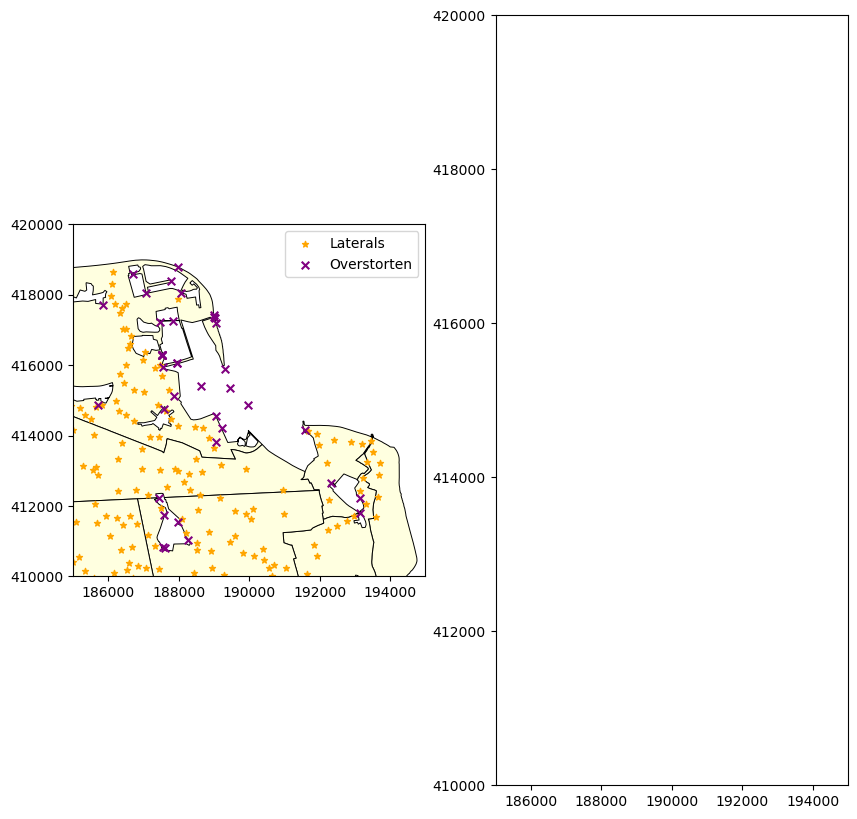

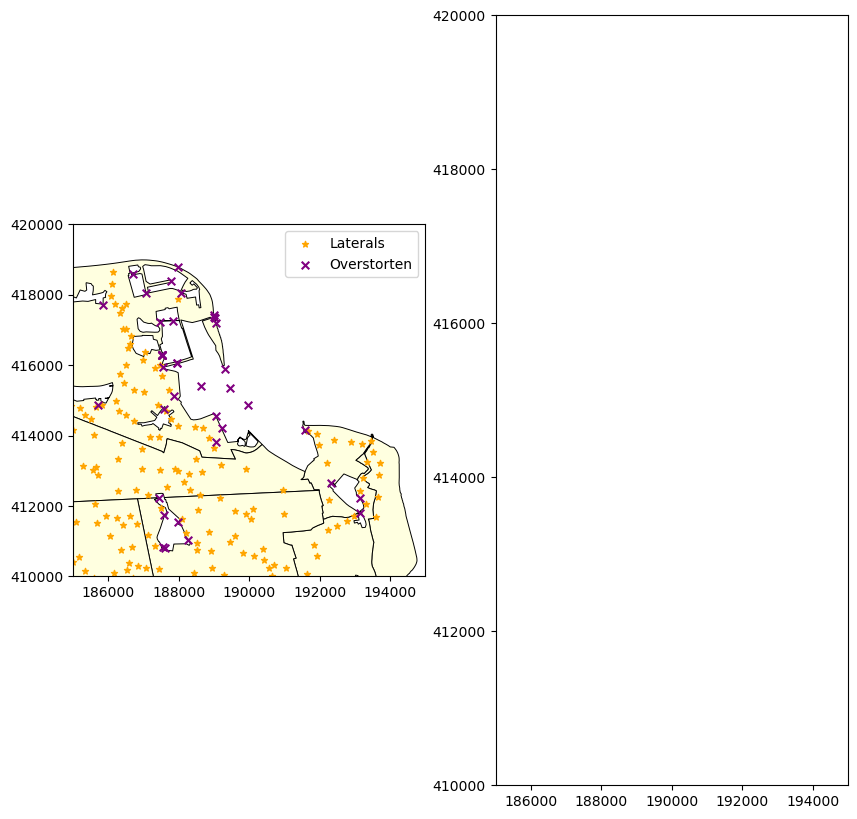

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 10))

gdf_wagmod.plot(ax=ax1, fc="lightyellow", edgecolor='black', lw=0.7)
gdf_laterals.plot(ax=ax1, color = 'orange', marker = '*', markersize = 20, label='Laterals')
gdf_overstorten.plot(ax=ax1, color = 'purple', marker='x',markersize = 30, label='Overstorten')

ax1.set_xlim(185000, 195000)
ax1.set_ylim(410000, 420000)
ax2.set_xlim(185000, 195000)
ax2.set_ylim(410000, 420000)
ax1.legend()
fig

The attributes of the Wageningen model are joined to the laterals that are located inside the Wageningen model polygons, specifically to obtain the 'GAFIDEN' belonging to that polygon. This 'GAFIDEN' is the identifier that is used by output data of Wageningen model afvoer data. This will be used later on.

In [41]:
gdf_laterals_joined = gpd.sjoin(gdf_laterals, gdf_wagmod, how='left')
gdf_laterals_joined.head()

,Opp_hactar,X,Y,geometry,type,index_right,GAFIDEN
CODE,,,,,,,
2011720L,30.109247,153611.0,411394.0,POINT (153610.957 411394.440),laterals,41.0,205
1087820L,3.054930,179156.0,417650.0,POINT (179156.491 417649.850),laterals,192.0,108b
2341490L,13.678861,170792.0,386422.0,POINT (170792.129 386422.037),laterals,165.0,234c
1130423L,20.861191,197661.0,398076.0,POINT (197661.249 398076.213),laterals,37.0,113
2613972L,6.890049,177393.0,389692.0,POINT (177393.001 389692.403),laterals,51.0,261a


Not all laterals turned out to intersect with Wageningen Model polygons, and therefore could not be assigned a GAFIDEN directly. They were therefore snapped to the nearest polygon, and for good administration I also saved them separately. There is a chance of making mistakes in this process, though we don't expect the results to be unacceptable.

<AxesSubplot:>

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

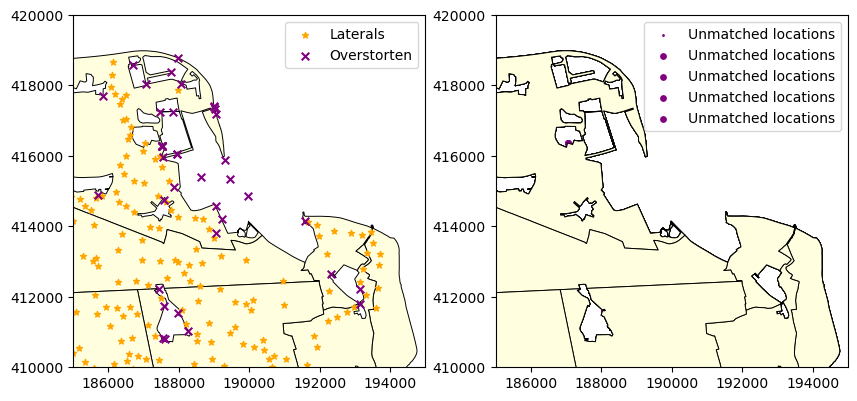

<Figure size 640x480 with 0 Axes>

In [42]:
gdf_missing = gdf_laterals_joined.loc[gdf_laterals_joined['index_right'].isna()]
gdf_missing.plot(ax=ax2, color = 'purple', marker='o',markersize = 15, label = 'Unmatched locations')
gdf_missing.to_file(join(path_script, r'output\shapefiles\lateralen_unmatched'))

gdf_wagmod.plot(ax=ax2, fc="lightyellow", edgecolor='black', lw=0.7)
ax2.legend()
fig

Per scenario: 
1) list the files inside the relevant folder
2) Create an empty list that will later contain the Wageningen Model data for this scenario for all regions
3) Per Region:
    - Read metadata from the top of the file to extract the model number
    - Read the actual data 
    - Convert the numeral time steps into a datetime
    - Add the data to the list that was made in step 2
4) Combine all the dataframes in the list into one dataframe

# Landelijke afvoer

In [67]:
join(inputfolder, scenario, region)

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\input/timeseries/landelijk/ghg120\\GHG120-105.00P'

In [72]:
inputfolder = join(path_script,r'input/timeseries/landelijk/')
scenarios = os.listdir(inputfolder)

for scenario in scenarios:
    wagmodFiles = os.listdir(join(inputfolder, scenario))
    
    ## Read Wageningen model output (discharges) per region, and multiply by the area belonging to each lateral
    ls_wagmodoutput = []
    
    for region in wagmodFiles:
        
        metadata_region = pd.read_csv(join(inputfolder, scenario, region), nrows=1, skiprows=[0,2], header=None)[0][0]
        model = re.search('model:(.*) (?:van|met winterbui)', metadata_region).group(1)
                
        df_region = pd.read_csv(
                join(inputfolder, scenario, region), 
                header=4, 
                delim_whitespace=True, 
                usecols=['-I-','-QC-'],
                )

        df_region=df_region.set_index(
                pd.to_datetime(df_region['-I-'],
                origin=pd.Timestamp('2010-11-08 23:00:00'),
                unit='h')
            ).drop(labels=['-I-'], axis='columns').rename(columns={'-QC-':model})
        
        ls_wagmodoutput.append(df_region)

    # The result is a list containing dataframes as items
    ls_wagmodoutput, len(ls_wagmodoutput)

    # Combine the dataframes into one big dataframe
    df_wagmodoutput = pd.concat(ls_wagmodoutput, axis=1, verify_integrity=True).T * 10 / 3600
    
    # Set the index to be only the 'GAFIDEN'
    for i in range(len(df_wagmodoutput.index)):
        ID =df_wagmodoutput.index[i].split(' ')[0]
        df_wagmodoutput.loc[df_wagmodoutput.index[i],'GAFIDEN'] = ID

    ### Multiplication
    gdf_laterals_joined['Latid'] = gdf_laterals_joined.index
    output_laterals = gdf_laterals_joined.merge(df_wagmodoutput, on='GAFIDEN', how='left')
    output_laterals.set_index('Latid', inplace=True)
    output_laterals2 = output_laterals.iloc[:,8:].multiply(output_laterals['Opp_hactar'],axis='index').T

    output_laterals2.to_csv(join(path_script, r'output\timeseries\landelijk', scenario + '.csv'))

([                     105 met winterbui:120mm in 3 dagen
  -I-                                                    
  2010-11-09 00:00:00                             0.02478
  2010-11-09 01:00:00                             0.02461
  2010-11-09 02:00:00                             0.02446
  2010-11-09 03:00:00                             0.02433
  2010-11-09 04:00:00                             0.02422
  ...                                                 ...
  2010-11-25 18:00:00                             0.04344
  2010-11-25 19:00:00                             0.04337
  2010-11-25 20:00:00                             0.04329
  2010-11-25 21:00:00                             0.04322
  2010-11-25 22:00:00                             0.04314
  
  [407 rows x 1 columns],
                       106 met winterbui:120mm in 3 dagen
  -I-                                                    
  2010-11-09 00:00:00                             0.02069
  2010-11-09 01:00:00                      

([                         105
  -I-                         
  2010-11-09 00:00:00  0.02494
  2010-11-09 01:00:00  0.02489
  2010-11-09 02:00:00  0.02485
  2010-11-09 03:00:00  0.02481
  2010-11-09 04:00:00  0.02477
  ...                      ...
  2023-11-08 19:00:00  0.00000
  2023-11-08 20:00:00  0.00000
  2023-11-08 21:00:00  0.00000
  2023-11-08 22:00:00  0.00000
  2023-11-08 23:00:00 -0.05224
  
  [113952 rows x 1 columns],
                           106
  -I-                         
  2010-11-09 00:00:00  0.02099
  2010-11-09 01:00:00  0.02098
  2010-11-09 02:00:00  0.02097
  2010-11-09 03:00:00  0.02096
  2010-11-09 04:00:00  0.02095
  ...                      ...
  2023-11-08 19:00:00  0.00196
  2023-11-08 20:00:00  0.00247
  2023-11-08 21:00:00  0.00295
  2023-11-08 22:00:00  0.00340
  2023-11-08 23:00:00  0.00383
  
  [113952 rows x 1 columns],
                          107a
  -I-                         
  2010-11-09 00:00:00  0.02911
  2010-11-09 01:00:00  0.02919
  2010

KeyboardInterrupt: 

In [63]:
join(path_script, r'output\timeseries', scenario)

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\output\\timeseries\\hist'

# Overstorten

In [9]:
scenario = scenarios[0]
overstortFiles = [overstorten_data_path + '//' + scenario+ '/' + year for year in os.listdir(overstorten_data_path + '//' + scenario)]
ls_overstortFiles = []

for path_xml in overstortFiles:
    # First, read the xml file, extract the root. Then, get all the elements named 'series'.
    ls_year = []
    xml = etree.parse(path_xml)
    root = xml.getroot()
    series = [child for child in root.getchildren() if 'series' in child.tag]

    # To each overstort belongs a series. The series contains a header with metadata (for the ID) and the actual data (events).
    for serie in series:
        # Extract the ID from the metadata. Used as column header in output.
        header = serie.find('{http://www.wldelft.nl/fews/PI}header')
        id = header.find('{http://www.wldelft.nl/fews/PI}stationName').text
        
        # Extract the actual data and reformat into a dataframe wtih a datetime index. 
        events = serie.findall('{http://www.wldelft.nl/fews/PI}event')
        df = pd.DataFrame([i.values() for i in events])
        index = pd.DatetimeIndex(pd.to_datetime(df[0]+' '+df[1], format="%Y-%m-%d %H:%M:%S"))
        output1 = pd.DataFrame({id: df[2].values}, index=index)
        output = pd.to_numeric(output1[id]).div(3600)
        # Add output to a list of dataframes that will contain all outputs from all overstorten.
        ls_year.append(output)

    # Combine outputs series vertically, merging on the datetime index. Then add the output of this year to the list of outputs from all years.
    df_year = pd.concat(ls_year,axis='columns',verify_integrity=True)
    ls_overstortFiles.append(df_year)

# Combine outputs from different years horizontally
final = pd.concat(ls_overstortFiles,axis='index',verify_integrity=True)
final.to_csv('output_overstorten.csv')

In [11]:
files_xlsx = glob.glob(overstorten_data_path + '/*.xlsx')


In [12]:
for file in files_xlsx:
    df = pd.read_excel(file, skiprows=3)
    index_col = df['code OS']
    data = df.filter(regex='Unnamed',axis='columns')
    data = data.div(3600)
    data.columns = range(1,76)
    data.index = index_col
    data_transposed = data.T
    data_transposed.to_csv(abspath(join(path_script, '..', '07_Rapportage',splitext(basename(file))[0])))
    